# Projekt 2 
### P. Fijałkowski, M. Krzyziński, T. Nocoń

## Inżynieria cech, wstępne modelowanie 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [23]:
online_shopping = pd.read_csv("online_shoppers_intention.csv")
data = online_shopping.copy() # robimy zmiany na tej ramce ale orginal nie ruszamy

Tak jak ustalilismy przy poprzednij czesci projetku, dla problemu klasterzacji przed przedjsciem do jakich kolwiek czynnosci grupujacych nalezy znormalziowac zmienne do wpsolnego zakersu warotosci, czyli przedzialu [0,1]. Ponadto nalezy zajac sie zmeinnymymi typu kategorycznego i je pozamieniac na wartosci liczobwe.

Zajmijmy sie najpierw pierwsza z wymganych czynoosci. W tym celu uzyejmy skalowania minimaxowego. W komorce poniezej jest lista kolumn, ktorych to dotyczy.

In [24]:
numeric = data.describe().keys()
data[numeric] # tylko zmieznne liczbowe

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,1,1,1,1
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,1,2
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,4,1,9,3
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,3,2,2,4
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,3,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,4,6,1,1
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,3,2,1,8
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,3,2,1,13
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,2,2,3,11


Na podstwie powyzszej ramki decydujemy sie normalziwac nastepujace kolumny:

In [25]:
normalization = ['Administrative','Administrative_Duration', 'Informational', 'Informational_Duration',
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']
norm = MinMaxScaler()
data[normalization] = norm.fit_transform(data[normalization])
# z porzedniej czesci pamietamy, ze SpecialDay ma juz znoramlizowane wartosci, zatem:
normalization.append("SpecialDay")

Dla pozostałych danych numerycznych zastosujemy encoder. Zeby ustalic jak to zrobimy, zobaczmy najpierw jaki rozkald liczebny ma kazda z pozostałych kolumn numerycznych.

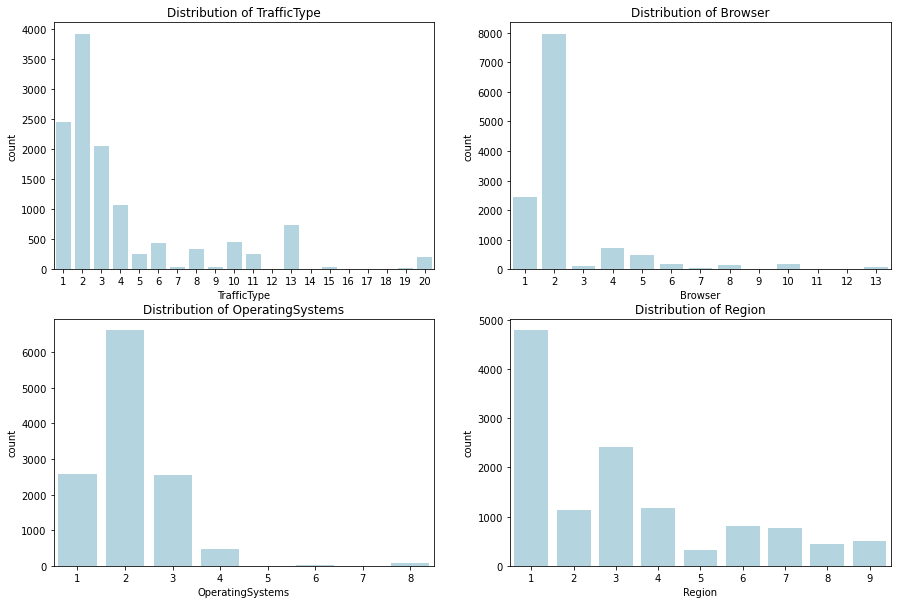

In [26]:
categorical = list(set(numeric) - set(normalization))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i in range(0, len(categorical)):
    sns.countplot(data=data, x=categorical[i], 
                  ax=axes[i//2, i%2], color = "lightblue").set_title('Distribution of %s' % (categorical[i]))
    

To co juz zuwazlismy, poprzednio to skośnoś wykresow. Wnioskiem z tego jest fakt, ze niewielka liczba kategorii kolumny odpowdia za wiekszosc wynikow. Stad wniosek, mozemy dla kazdej kolumny wziac pierwsze najbardziej znaczace kategorie, pozosotale natomaiast zaklasyfikwoac jako others. Gdy zrobimy taki spryrtny manewr to możemy użyc one hot encodera.

In [35]:
def One_hot_enocder(dic, data):
    for m_r in dic.keys():
        most_import = data[m_r].value_counts()[:most_relevant[m_r]].index.tolist()
        data[m_r] = data[m_r].transform(lambda x: x if (x in most_import) else 'others').astype(str)
    
        encoder = OneHotEncoder(sparse=False)
        one_hot = pd.DataFrame(encoder.fit_transform(data[[m_r]]))
        one_hot.columns = encoder.get_feature_names([m_r])
        data = pd.concat([data, one_hot], axis=1)
        data = data.drop(m_r, axis=1)
    return data

Pozosatlo jeszce kilka kolumn nad ktrorymi musimy popracowac. Sa to kolumna `Month`, której wartosci w łatwy sposob mozmey zamienic na wartosci numeryczne, kolumna `VisitorType`, dla której użyjemy również one hot enconding. Pozatym są to jeszce zmienne, ktorych wartosci sa binarne, czyli kolumna `Weekend` i ta najbardziej intersuajca `Revenue`.

Zachowujac pewnien ciag dokonczmy w peleni one hot encoding i potem ajmiemy sie reszta

In [37]:
most_relevant = {"TrafficType" : 4,
                 "Browser" : 2,
                 "OperatingSystems" : 3,
                 "Region" : 4, 
                 "VisitorType" : len(data["VisitorType"].value_counts().index)}
data = One_hot_enocder(most_relevant, data)

# Kolumns `Month`

In [46]:
months = data["Month"].value_counts().index.tolist() # nie jest po kolei
for i in range(len(months)):
    data["Month"] = data["Month"].replace(months[i], i)

# Ostatntnie dwie kolumny

In [ ]:
booleans =  ['Weekend', 'Revenue']
for boolen in booleans:
    data[boolen] = data[boolen].transform(lambda x: 1 if x else 0)

W tej chwili mamy juz w calosci przystsowane dane do dalszych rozwazn i dzialan.

In [51]:
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,OperatingSystems_3,OperatingSystems_others,Region_1,Region_2,Region_3,Region_4,Region_others,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,0.000000,0.0,0.0,0.002837,0.001000,0.000000,0.500000,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.000000,0.0,0.0,0.001418,0.000000,1.000000,1.000000,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.000000,0.000000,0.0,0.0,0.002837,0.000042,0.250000,0.700000,0.000000,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.000000,0.0,0.0,0.014184,0.009809,0.100000,0.250000,0.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.111111,0.042663,0.0,0.0,0.075177,0.027883,0.035714,0.145153,0.033839,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12326,0.000000,0.000000,0.0,0.0,0.007092,0.007280,0.000000,0.106667,0.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12327,0.000000,0.000000,0.0,0.0,0.008511,0.002880,0.416667,0.433333,0.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12328,0.148148,0.022067,0.0,0.0,0.021277,0.005408,0.000000,0.105263,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
